In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from cycler import cycler

cmap = plt.get_cmap("tab10").colors
plt.rc('axes', prop_cycle=(cycler('color', cmap)))


In [95]:
# Loading in SOPHIE Data
ept80 = "ept80"
sophie80df = pd.read_csv("Data/SOPHIE_{}.csv".format(ept80.upper()))
sophie80df['Date_UTC'] = pd.to_datetime(sophie80df['Date_UTC'])

# choosing only sophie onsets
sophie80onsetdf = sophie80df.iloc[np.where(sophie80df['Phase']==2)]
sophie80onsetdf = sophie80onsetdf.reset_index(drop=True)


# reading in Newell data
newelldf = pd.read_csv(
    'Data/substorms-newell-20000101_000000_to_20070101_000000.csv')
newelldf['Date_UTC'] = pd.to_datetime(newelldf['Date_UTC'])

# reading in Frey data
freydf = pd.read_csv(
    'Data/substorms-frey-20000101_000000_to_20070101_000000.csv')
freydf['Date_UTC'] = pd.to_datetime(freydf['Date_UTC'])

# reading in IMAGE data
imagedf = pd.read_csv('Data/IMAGEtimes.csv')
imagedf['Date_UTC'] = pd.to_datetime(imagedf['Date_UTC'])

# reading in chumpb onsets
chudf = pd.read_csv('Data/ChuMPB.txt',
                    header=None, names=['Date_UTC'])
chudf['Date_UTC'] = pd.to_datetime(
    chudf['Date_UTC'], format='%Y %m %d %H %M %S')

# reading in mcpsml onsets
mcpsmldf = pd.read_fwf("Data/McPSML.txt")
mcpsmldf["Date_UTC"] = pd.to_datetime(
    mcpsmldf[["year", "mo", "da", "hr", "mn"]].astype(str).apply(" ".join, 1),
    format="%Y %m %d %H %M",
)
mcpsmldf.drop(["year", "mo", "da", "hr", "mn", "sc"], axis=1, inplace=True)
mcpsmldf = mcpsmldf[["Date_UTC", "baymin", "delbay", "hafwid"]]

# reading in mcpmpb onsets
mcpmpbdf = pd.read_fwf("Data/McPMPB.txt")
mcpmpbdf.set_axis(
    ["Onset Time", "Max Time", "End Time", "Vons", "Vmax", "Vend", "Area"],
    axis=1,
    inplace=True,
)
mcpmpbdf = mcpmpbdf.drop(labels=0, axis=0)
mcpmpbdf["Onset Time"] = pd.to_datetime(
    mcpmpbdf["Onset Time"], format="%Y %m %d %H %M %S"
)
mcpmpbdf["Max Time"] = pd.to_datetime(mcpmpbdf["Max Time"], format="%Y %m %d %H %M %S")
mcpmpbdf["End Time"] = pd.to_datetime(mcpmpbdf["End Time"], format="%Y %m %d %H %M %S")
mcpmpbdf["Date_UTC"] = pd.to_datetime(
    mcpmpbdf["Onset Time"], format="%Y %m %d %H %M %S"
)
#reading in particle injections
bypidf = pd.read_csv("Data/BYparticleinjections.csv")
bypidf['Date_UTC'] = pd.to_datetime(bypidf['Date_UTC'])

#reading in BY SML
bysmldf = pd.read_csv("Data/BYSML.csv")
bysmldf['Date_UTC'] = pd.to_datetime(bysmldf['Date_UTC'])

#reading in storm list
stormlistdf = pd.read_csv("Data/stormlist.csv")
stormlistdf["Start Time"] = pd.to_datetime(stormlistdf["Start Time"])
stormlistdf["End Time"] = pd.to_datetime(stormlistdf["End Time"])

In [96]:
tstart = "2000-05-18"
tend = "2003-01-01"

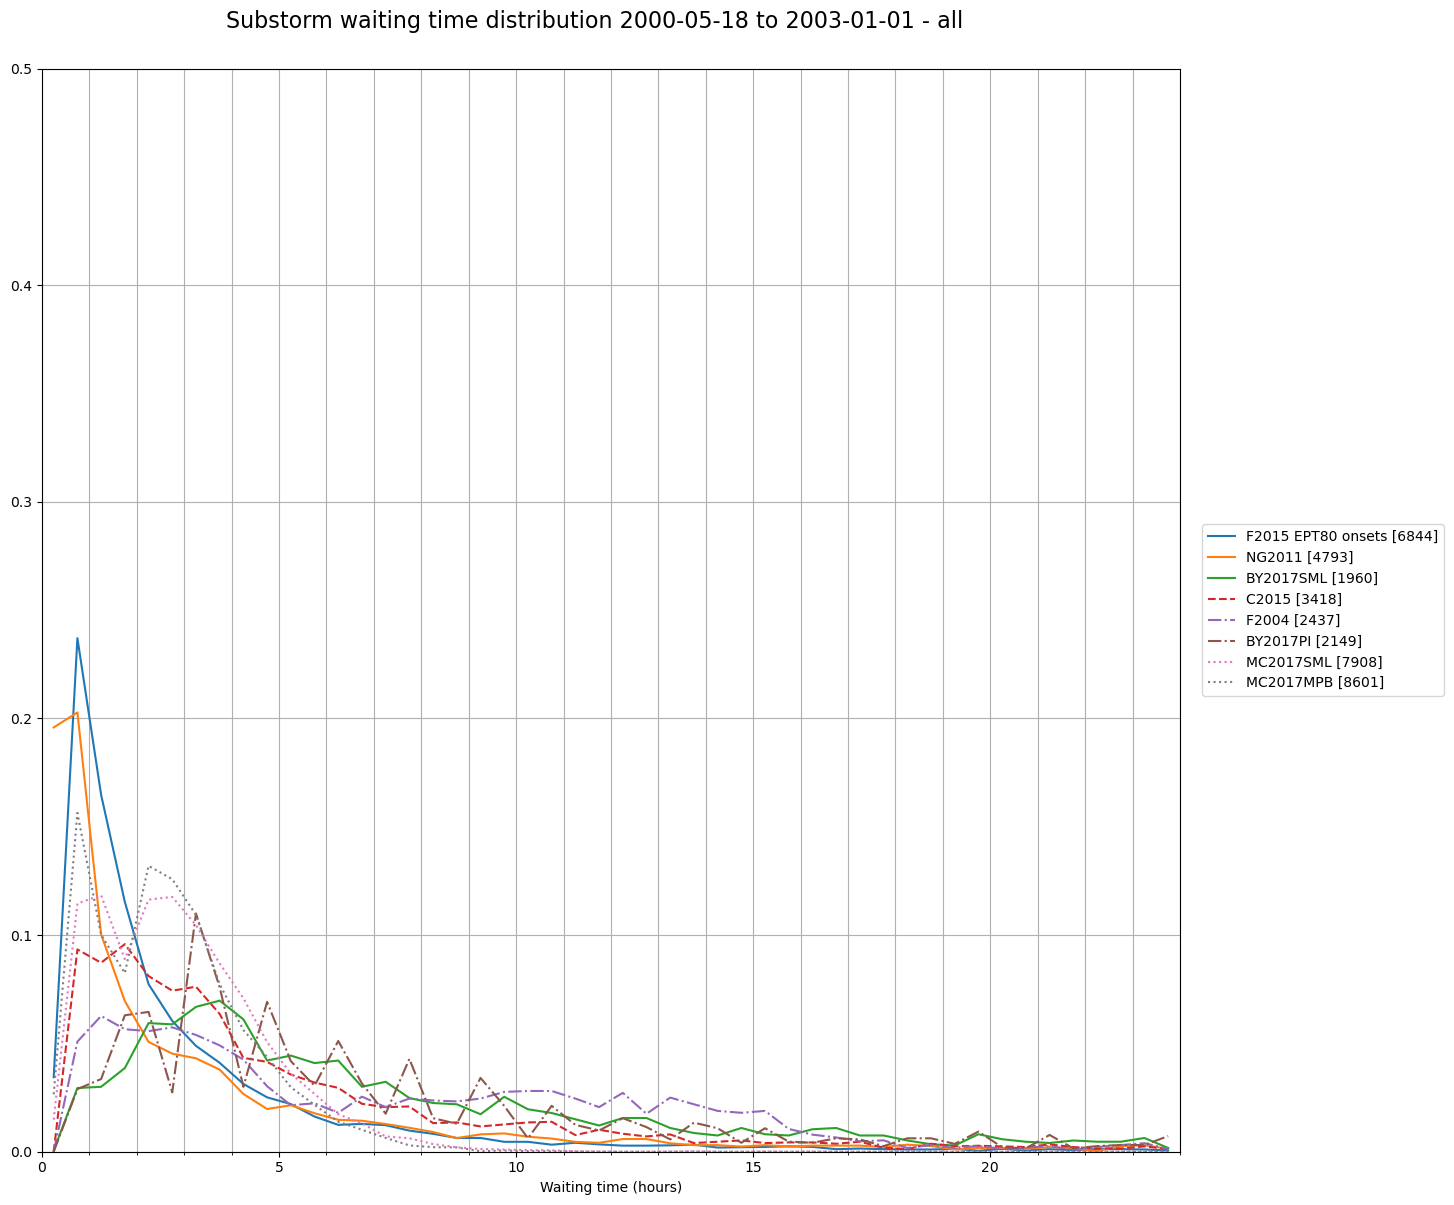

In [97]:
def wta_func(tstart, tend, array):
    starttime = pd.to_datetime(tstart)
    endtime = pd.to_datetime(tend)
    arrayslice = array['Date_UTC'][array['Date_UTC'].between(starttime,endtime)].reset_index(drop=True)
    x = np.array(pd.to_timedelta(np.diff(arrayslice))/pd.to_timedelta(1,'h'))
    d = {'Waiting Time':x}
    df = pd.DataFrame(d)
    return df

def waitingtime_hist(array):
    x, y = np.histogram(array['Waiting Time'],bins=np.arange(0,24.5,.5))
    y = y+.25
    y = y[:-1]
    d = {'Waiting Time':y,'Density':x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

def onset_event_number(array, time_start, time_end):
    starttime = pd.to_datetime(time_start)
    endtime = pd.to_datetime(time_end)
    arrayslice = array[array['Date_UTC'].between(starttime, endtime)]  
    x = arrayslice["Date_UTC"].size
    return x    

onsetlists = [sophie80onsetdf, newelldf, bysmldf, chudf, freydf, bypidf, mcpsmldf, mcpmpbdf]
labels = ['F2015 EPT80 onsets', 'NG2011', 'BY2017SML','C2015', 'F2004', 'BY2017PI','MC2017SML', 'MC2017MPB']
onsetnumbers = [onset_event_number(i,tstart,tend) for i in onsetlists]
labels = [labels[i] + ' ' +str([onsetnumbers[i]]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot', 'dotted']
wtsdf = [wta_func(tstart,tend, i) for i in onsetlists]
wts = [waitingtime_hist(i) for i in wtsdf]
fig, axes = plt.subplots(figsize=(12,12))

for i in range(len(onsetlists)):
    if i < 3:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[0])
    if 3 <= i < 4:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[1])
    if 4 <= i < len(onsetlists)-2:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[2])
    if len(onsetlists)-2 <= i:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[3])

axes.set_ylim(0,.5)    
axes.set_xlim(0,24)
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Waiting time (hours)')
axes.grid(True,'both')
fig.suptitle('Substorm waiting time distribution 2000-05-18 to 2003-01-01 - all', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()


## Storms


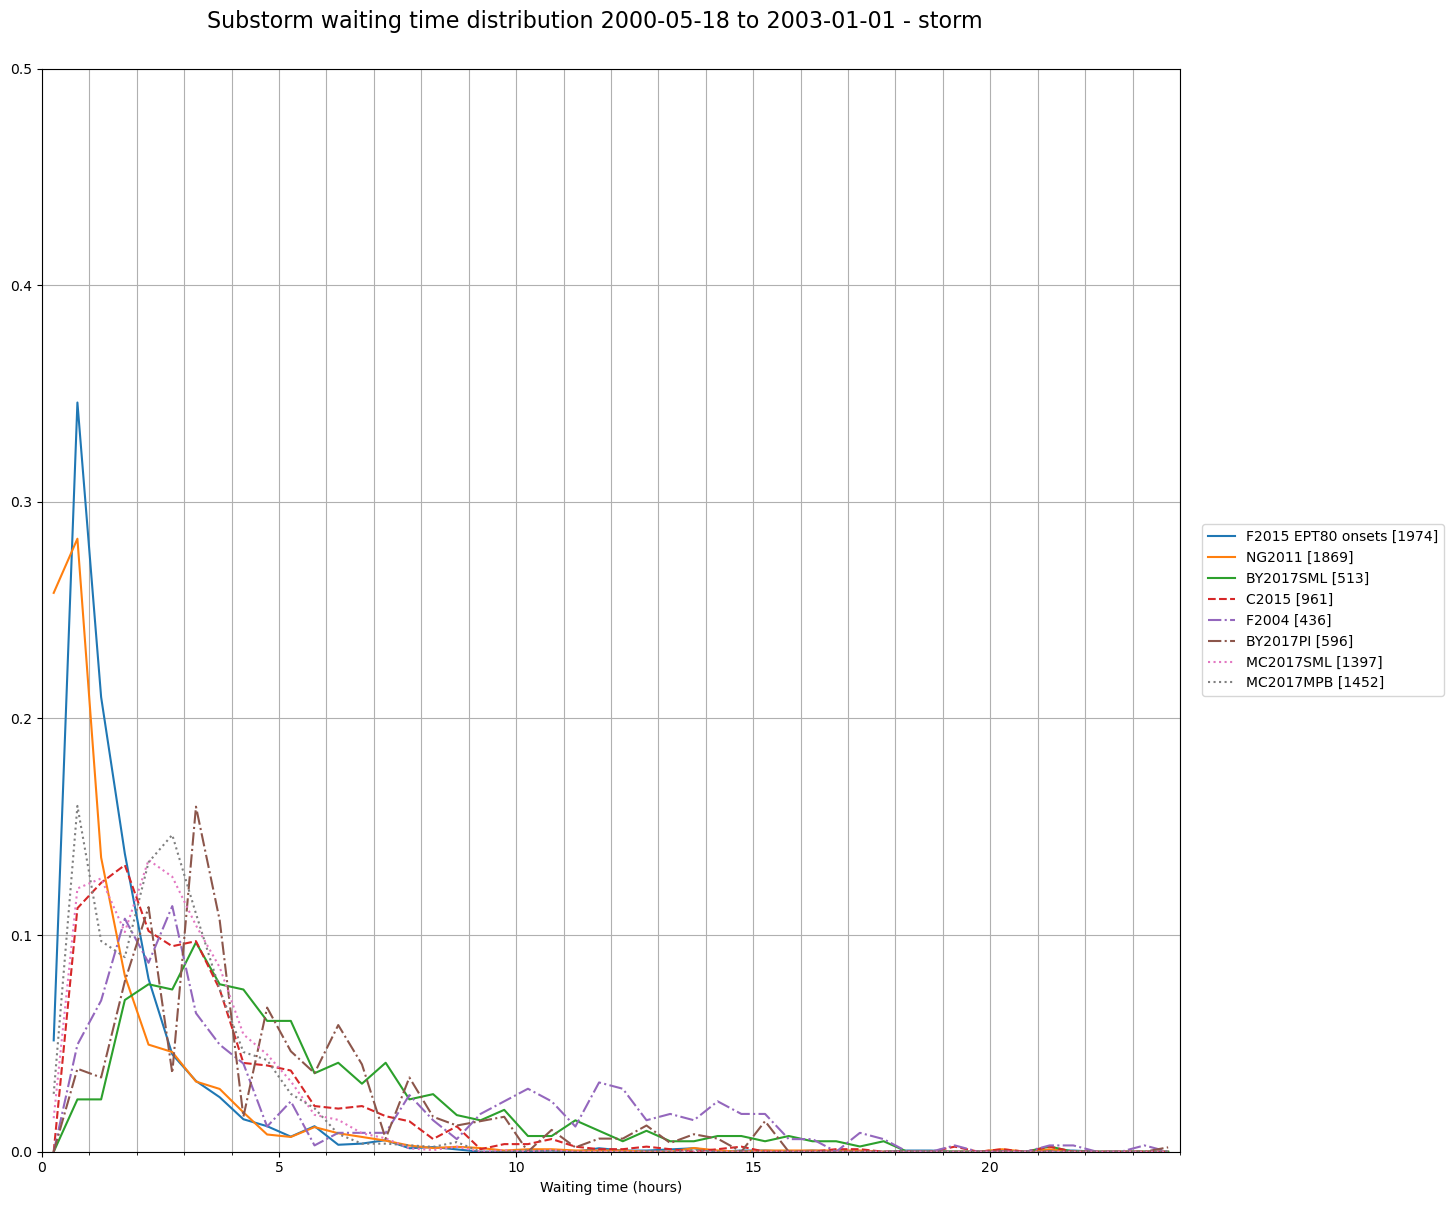

In [98]:
def wta_func(tstart, tend, array):
    starttime = pd.to_datetime(tstart)
    endtime = pd.to_datetime(tend)
    stormstartslice = stormlistdf["Start Time"][
        stormlistdf["Start Time"].between(starttime, endtime)
    ].reset_index(drop=True)
    stormendslice = stormlistdf["End Time"][
        stormlistdf["End Time"].between(starttime, endtime)
    ].reset_index(drop=True)
    storms = [
        [stormstartslice[i], stormendslice[i]] for i in range(len(stormstartslice))
    ]

    stormwaitingtimes = []
    for i in range(len(storms)):
        arrayslice = array["Date_UTC"][
            array["Date_UTC"].between(storms[i][0], storms[i][1], inclusive='both')
        ].reset_index(drop=True)
        stormwaitingtimes.append(
            pd.to_timedelta(np.diff(arrayslice)) / pd.to_timedelta(1, unit="h")
        )
    flat_list = [item for sublist in stormwaitingtimes for item in sublist]
    d = {"Waiting Time": flat_list}
    df = pd.DataFrame(d)
    return df

def waitingtime_hist(array):
    x, y = np.histogram(
        array["Waiting Time"], bins=np.arange(0, 24.5, 0.5)
    )
    y = y + 0.25
    y = y[:-1]
    d = {"Waiting Time": y, "Density": x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

def onset_event_number(array, time_start, time_end):
    starttime = pd.to_datetime(time_start)
    endtime = pd.to_datetime(time_end)

    stormstartslice = stormlistdf["Start Time"][
        stormlistdf["Start Time"].between(starttime, endtime)
    ].reset_index(drop=True)
    stormendslice = stormlistdf["End Time"][
        stormlistdf["End Time"].between(starttime, endtime)
    ].reset_index(drop=True)
    storms = [
        [stormstartslice[i], stormendslice[i]] for i in range(len(stormstartslice))
    ]

    substorms_in_storms = []
    for i in range(len(storms)):
        arrayslice = array["Date_UTC"][
            array["Date_UTC"].between(storms[i][0], storms[i][1], inclusive='both')
        ].reset_index(drop=True)
        substorms_in_storms.append(arrayslice)
    
    flat_list = [item for sublist in substorms_in_storms for item in sublist]
    return len(flat_list)

onsetlists = [sophie80onsetdf, newelldf, bysmldf, chudf, freydf, bypidf, mcpsmldf, mcpmpbdf]
labels = ['F2015 EPT80 onsets', 'NG2011', 'BY2017SML','C2015', 'F2004', 'BY2017PI','MC2017SML', 'MC2017MPB']
onsetnumbers = [onset_event_number(i,tstart,tend) for i in onsetlists]
labels = [labels[i] + ' ' +str([onsetnumbers[i]]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot', 'dotted']
wtsdf = [wta_func(tstart,tend, i) for i in onsetlists]
wts = [waitingtime_hist(i) for i in wtsdf]
fig, axes = plt.subplots(figsize=(12,12))

for i in range(len(onsetlists)):
    if i < 3:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[0])
    if 3 <= i < 4:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[1])
    if 4 <= i < len(onsetlists)-2:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[2])
    if len(onsetlists)-2 <= i:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[3])

axes.set_ylim(0,.5)    
axes.set_xlim(0,24)
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Waiting time (hours)')
axes.grid(True,'both')
fig.suptitle('Substorm waiting time distribution 2000-05-18 to 2003-01-01 - storm', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()

## Nonstorms

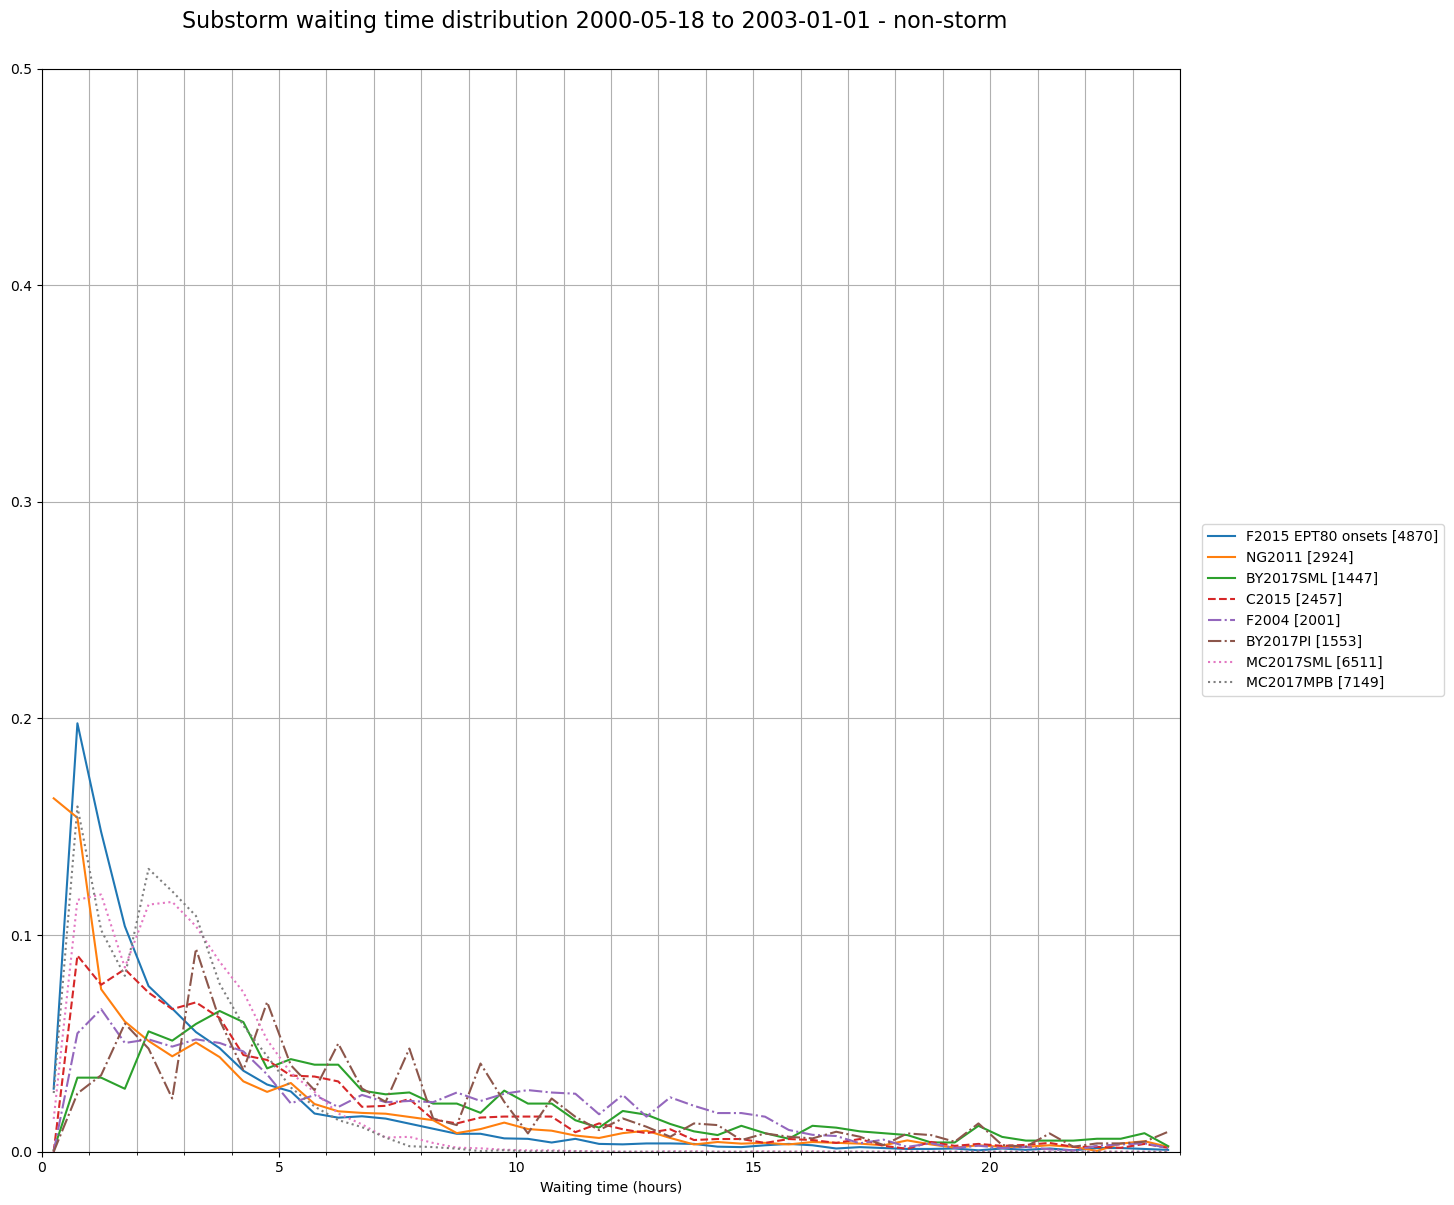

In [99]:
def wta_func(tstart, tend, array):
    starttime = pd.to_datetime(tstart)
    endtime = pd.to_datetime(tend)
    stormstartslice = stormlistdf["Start Time"][
        stormlistdf["Start Time"].between(starttime, endtime)
    ].reset_index(drop=True)
    stormendslice = stormlistdf["End Time"][
        stormlistdf["Start Time"].between(starttime, endtime)
    ].reset_index(drop=True)
    nonstormstart = [starttime]
    nonstormstart[1:] = stormendslice
    nonstormend = [endtime]
    nonstormend[:-1] = stormstartslice
    nonstorm = [[nonstormstart[i], nonstormend[i]] for i in range(len(nonstormstart))]

    nonstormwaitingtimes = []
    for i in range(len(nonstorm)):
        arrayslice = array["Date_UTC"][
            array["Date_UTC"].between(nonstorm[i][0], nonstorm[i][1], inclusive='neither')
        ].reset_index(drop=True)
        nonstormwaitingtimes.append(
            pd.to_timedelta(np.diff(arrayslice)) / pd.to_timedelta(1, unit="h")
        )
    flat_list = [item for sublist in nonstormwaitingtimes for item in sublist]
    d = {"Waiting Time": flat_list}
    df = pd.DataFrame(d)
    return df

def waitingtime_hist(array):
    x, y = np.histogram(
        array["Waiting Time"], bins=np.arange(0, 24.5, 0.5)
    )
    y = y + 0.25
    y = y[:-1]
    d = {"Waiting Time": y, "Density": x/np.sum(x)}
    df = pd.DataFrame(d)
    return df

def onset_event_number(array, time_start, time_end):
    starttime = pd.to_datetime(time_start)
    endtime = pd.to_datetime(time_end)

    stormstartslice = stormlistdf["Start Time"][
        stormlistdf["Start Time"].between(starttime, endtime)
    ].reset_index(drop=True)

    stormendslice = stormlistdf["End Time"][
        stormlistdf["Start Time"].between(starttime, endtime)
    ].reset_index(drop=True)

    nonstormstart = [starttime]
    nonstormstart[1:] = stormendslice
    nonstormend = [endtime]
    nonstormend[:-1] = stormstartslice
    nonstorm = [[nonstormstart[i], nonstormend[i]] for i in range(len(nonstormend))]

    substorm_in_nonstorm = []
    for i in range(len(nonstorm)):
        arrayslice = array["Date_UTC"][
            array["Date_UTC"].between(nonstorm[i][0], nonstorm[i][1], inclusive='neither')
        ].reset_index(drop=True)
        substorm_in_nonstorm.append(arrayslice)
    flat_list = [item for sublist in substorm_in_nonstorm for item in sublist]
    return len(flat_list)

onsetlists = [sophie80onsetdf, newelldf, bysmldf, chudf, freydf, bypidf, mcpsmldf, mcpmpbdf]
labels = ['F2015 EPT80 onsets', 'NG2011', 'BY2017SML','C2015', 'F2004', 'BY2017PI','MC2017SML', 'MC2017MPB']
onsetnumbers = [onset_event_number(i,tstart,tend) for i in onsetlists]
labels = [labels[i] + ' ' +str([onsetnumbers[i]]) for i in range(len(onsetlists))]

lines = ['solid','dashed','dashdot', 'dotted']
wtsdf = [wta_func(tstart,tend, i) for i in onsetlists]
wts = [waitingtime_hist(i) for i in wtsdf]
fig, axes = plt.subplots(figsize=(12,12))

for i in range(len(onsetlists)):
    if i < 3:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[0])
    if 3 <= i < 4:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[1])
    if 4 <= i < len(onsetlists)-2:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[2])
    if len(onsetlists)-2 <= i:
        axes.plot(wts[i]['Waiting Time'],wts[i]['Density'], label=labels[i],ls=lines[3])

axes.set_ylim(0,.5)    
axes.set_xlim(0,24)
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
axes.set_xlabel('Waiting time (hours)')
axes.grid(True,'both')
fig.suptitle('Substorm waiting time distribution 2000-05-18 to 2003-01-01 - non-storm', fontsize=16, y=1)
fig.legend(bbox_to_anchor=(1, .5), loc='center left')
fig.tight_layout()